In [46]:
import requests
import gzip
import io
from Bio import SeqIO
from Bio import AlignIO
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [47]:
# -----------------------------
# Step 1: Download Pfam-A.seed.gz
# -----------------------------
url = "https://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam35.0/Pfam-A.seed.gz"
response = requests.get(url, stream=True)
response.raise_for_status()

pfam_ids = ["PF00069", "PF00072"]  # Protein kinase + GPCR example
records_by_family = {pfam: [] for pfam in pfam_ids}

In [48]:
# -----------------------------
# Step 2: Parse manually, track #=GF AC
# -----------------------------
current_acc = None
block_lines = []

def process_block(block_lines, current_acc):
    """Convert collected lines into an alignment and store if matches PFAM IDs"""
    if not block_lines or current_acc not in records_by_family:
        return
    # Add missing Stockholm header and footer
    block_text = "# STOCKHOLM 1.0\n" + "".join(block_lines) + "//\n"
    handle = io.StringIO(block_text)
    alignment = AlignIO.read(handle, "stockholm")
    records_by_family[current_acc].extend(alignment)

with gzip.open(io.BytesIO(response.content), "rt", encoding="latin-1") as handle:
    for line in handle:
        if line.startswith("#=GF AC"):
            # Process previous block
            process_block(block_lines, current_acc)
            block_lines = [line]
            current_acc = line.split()[2].split(".")[0]  # strip version
        elif line.strip() == "//":  # end of block
            block_lines.append(line)
            process_block(block_lines, current_acc)
            block_lines = []
            current_acc = None
        else:
            block_lines.append(line)

for pfam, seqs in records_by_family.items():
    print(f"{pfam}: {len(seqs)} sequences")


PF00069: 38 sequences
PF00072: 52 sequences


In [14]:
print(records_by_family)

{'PF00069': [SeqRecord(seq=Seq('YSILKQIGSGGSSKV--FQVLN-EKKQIYAIKYVNLEEADNQTL------DSYR...PYV'), id='TTK_HUMAN/525-791', name='TTK_HUMAN', description='TTK_HUMAN/525-791', dbxrefs=['PDB; 5O91 A; 525-791;', 'PDB; 6TN9 A; 525-791;', 'PDB; 5EH0 A; 525-791;', 'PDB; 2X9E A; 525-791;', 'PDB; 6TNB A; 525-791;', 'PDB; 2ZMC A; 525-791;', 'PDB; 4CV8 A; 525-791;', 'PDB; 3WZJ A; 525-791;', 'PDB; 3WYX A; 525-791;', 'PDB; 3HMO A; 525-791;', 'PDB; 5AP3 A; 525-791;', 'PDB; 6GVJ A; 525-791;', 'PDB; 3HMP A; 525-791;', 'PDB; 4JS8 A; 525-791;', 'PDB; 4BI0 A; 525-791;', 'PDB; 3DBQ A; 525-791;', 'PDB; 3W1F A; 525-791;', 'PDB; 3CEK A; 525-791;', 'PDB; 3VQU A; 525-791;', 'PDB; 6B4W A; 525-791;', 'PDB; 6N6O A; 525-791;', 'PDB; 5EHL A; 525-791;', 'PDB; 4CV9 A; 525-791;', 'PDB; 3HMN A; 525-791;', 'PDB; 4C4F A; 525-791;', 'PDB; 5AP2 A; 525-791;', 'PDB; 5LJJ A; 525-791;', 'PDB; 5EI2 A; 525-791;', 'PDB; 5N93 A; 525-791;', 'PDB; 5EHO A; 525-791;', 'PDB; 5MRB A; 525-791;', 'PDB; 4BI2 A; 525-791;', 'PDB; 4JT3 A; 525-79

In [50]:
# === Add after you build `records_by_family` and `df` in your script ===
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE, trustworthiness
import umap.umap_ as umap   # pip install umap-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

In [52]:
# 1) Build corpus of sequences per entry (as strings) and labels (Pfam IDs)
seq_texts = []
labels = []
for pfam, seqs in records_by_family.items():
    for rec in seqs:
        # keep only the 20 standard AAs to avoid vectorizer noise
        s = ''.join([c for c in str(rec.seq) if c in "ACDEFGHIKLMNPQRSTVWY"])
        if len(s) >= 50:  # (optional) guard against very short fragments
            seq_texts.append(s)
            labels.append(pfam)

In [17]:
print(seq_texts)

['YSILKQIGSGGSSKVFQVLNEKKQIYAIKYVNLEEADNQTLDSYRNEIAYLNKLQQHSDKIIRLYDYEITDQYIYMVMECGNIDLNSWLKKKKSIDPWERKSYWKNMLEAVHTIHQHGIVHSDLKPANFLIVDGMLKLIDFGIANQMQPDTTSVVKDSQVGTVNYMPPEAIKDMSSSRENGKSKSKISPKSDVWSLGCILYYMTYGKTPFQQIINQISKLHAIIDPNHEIEFPDIPEKDLQDVLKCCLKRDPKQRISIPELLAHPYV', 'IETLGILGEGAGGSVSKCKLKNGSKIFALKVINTLNTDPEYQKQIFRELQFNRSFQSEYIVRYYGMFTDDENSSIYIAMEYMGGRSLDAIYKNLLERGGRISEKVLGKIAEAVLRGLSYLHEKKVIHRDIKPQNILLNENGQVKLCDFGVSGEAVNSLATTFTGTSFYMAPERIQGQPYSVTSDVWSLGLTILEVANGKFPCSSEKMAANIAPFELLMWILTFTPELKDEPESNIIWSPSFKSFIDYCLKKDSRERPSPRQMINHPWI', 'LVQLGKIGAGNSGTVVKALHVPDSKIVAKKTIPVEQNNSTIINQLVRELSIVKNVKPHENIITFYGAYYNQHINNEIIILMEYSDCGSLDKILSVYKRFVQRGTVSSKKTWFNELTISKIAYGVLNGLDHLYRQYKIIHRDIKPSNVLINSKGQIKLCDFGVSKKLINSIADTFVGTSTYMSPERIQGNVYSIKGDVWSLGLMIIELVTGEFPLGGHNDTPDGILDLLQRIVNEPSPRLPKDRIYSKEMTDFVNRCCIKNERERSSIHELLHHDLI', 'LEVVRHLGEGNGGAVSLVKHRNIFMARKTVYVGSDSKLQKQILRELGVLHHCRSPYIVGFYGAFQYKNNISLCMEYMDCGSLDAILREGGPIPLDILGKIINSMVKGLIYLYNVLHIIHRDLKPSNVVVNSRGEIKLCDFGVSGELVNSVAQTFVGTSTYMSPERIRGGKYTVKS

In [53]:
# 2) TF-IDF on character 3-grams (k-mers). You can try k=2..4; 3 is a nice default
vec = TfidfVectorizer(analyzer='char', ngram_range=(3,3), lowercase=False)
X_kmer = vec.fit_transform(seq_texts)   # sparse [n_samples, n_kmers]

In [54]:
# 3) 2-D reductions of the high-dim k-mer space
# 3a) UMAP (fast, preserves local neighborhoods)
umap2 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=0)
X_umap = umap2.fit_transform(X_kmer)

/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [55]:
# 3b) t-SNE (slower, sometimes crisper clusters). Start from 50D SVD for speed.
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=min(50, X_kmer.shape[1]-1), random_state=0)
X_svd = svd.fit_transform(X_kmer)
tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=0)
X_tsne = tsne.fit_transform(X_svd)



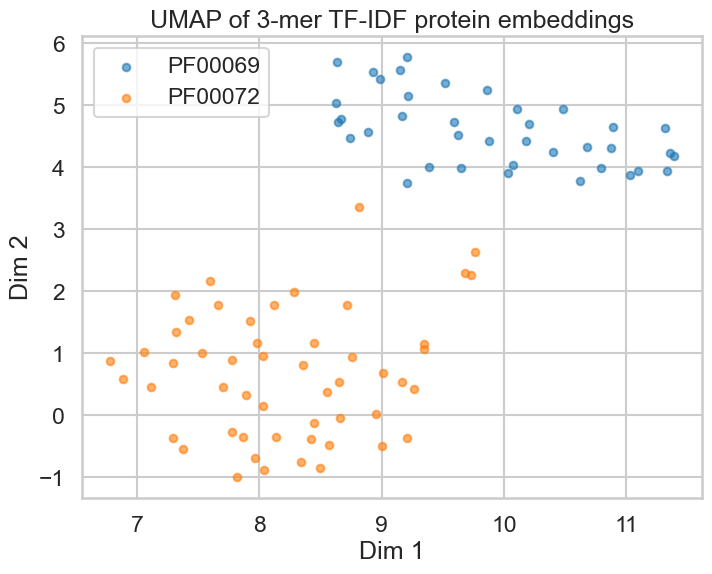

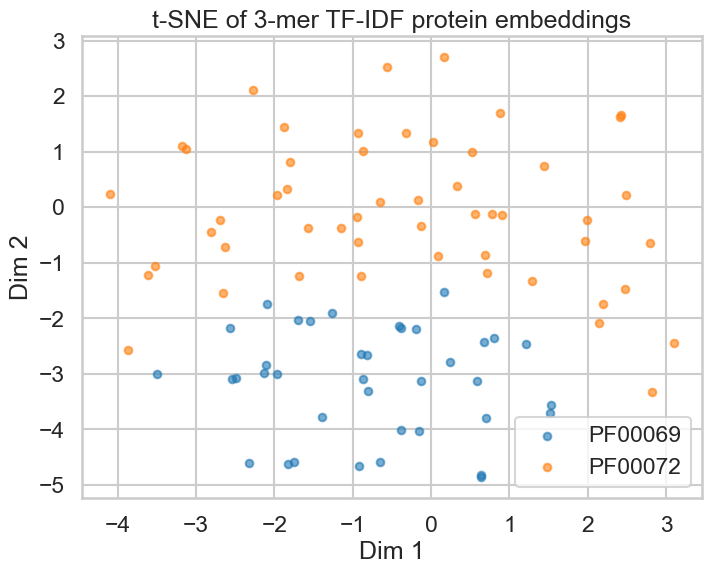

In [56]:
# 4) Make scatter plots comparable to your PCA plot
def scatter_2d(Z, labels, title):
    plt.figure(figsize=(8,6))
    fams = sorted(set(labels))
    for fam in fams:
        mask = np.array(labels) == fam
        plt.scatter(Z[mask,0], Z[mask,1], label=fam, alpha=0.6, s=30)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.show()

scatter_2d(X_umap, labels, "UMAP of 3-mer TF-IDF protein embeddings")
scatter_2d(X_tsne, labels, "t-SNE of 3-mer TF-IDF protein embeddings")



In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_2d(Z, labels, title):
    # Use a consistent style
    sns.set_context("talk")
    sns.set_style("whitegrid")

    fams = sorted(set(labels))
    palette = sns.color_palette("tab10", n_colors=len(fams))

    plt.figure(figsize=(7,7), dpi=300)
    for fam, color in zip(fams, palette):
        mask = np.array(labels) == fam
        plt.scatter(
            Z[mask,0],
            Z[mask,1],
            label=fam,
            alpha=0.7,
            s=40,
            edgecolor="k",
            linewidth=0.3,
            color=color
        )

    # Titles and labels
    plt.title(title, fontsize=16, weight="bold")
    plt.xlabel("UMAP-1", fontsize=16)
    plt.ylabel("UMAP-2", fontsize=16)

    # Legend inside the plot
    plt.legend(
        title="Pfam Families",
        loc="best",
        fontsize=16,
        title_fontsize=16,
        frameon=True,
        fancybox=True,
        framealpha=0.8
    )

    plt.tight_layout()
    plt.show()


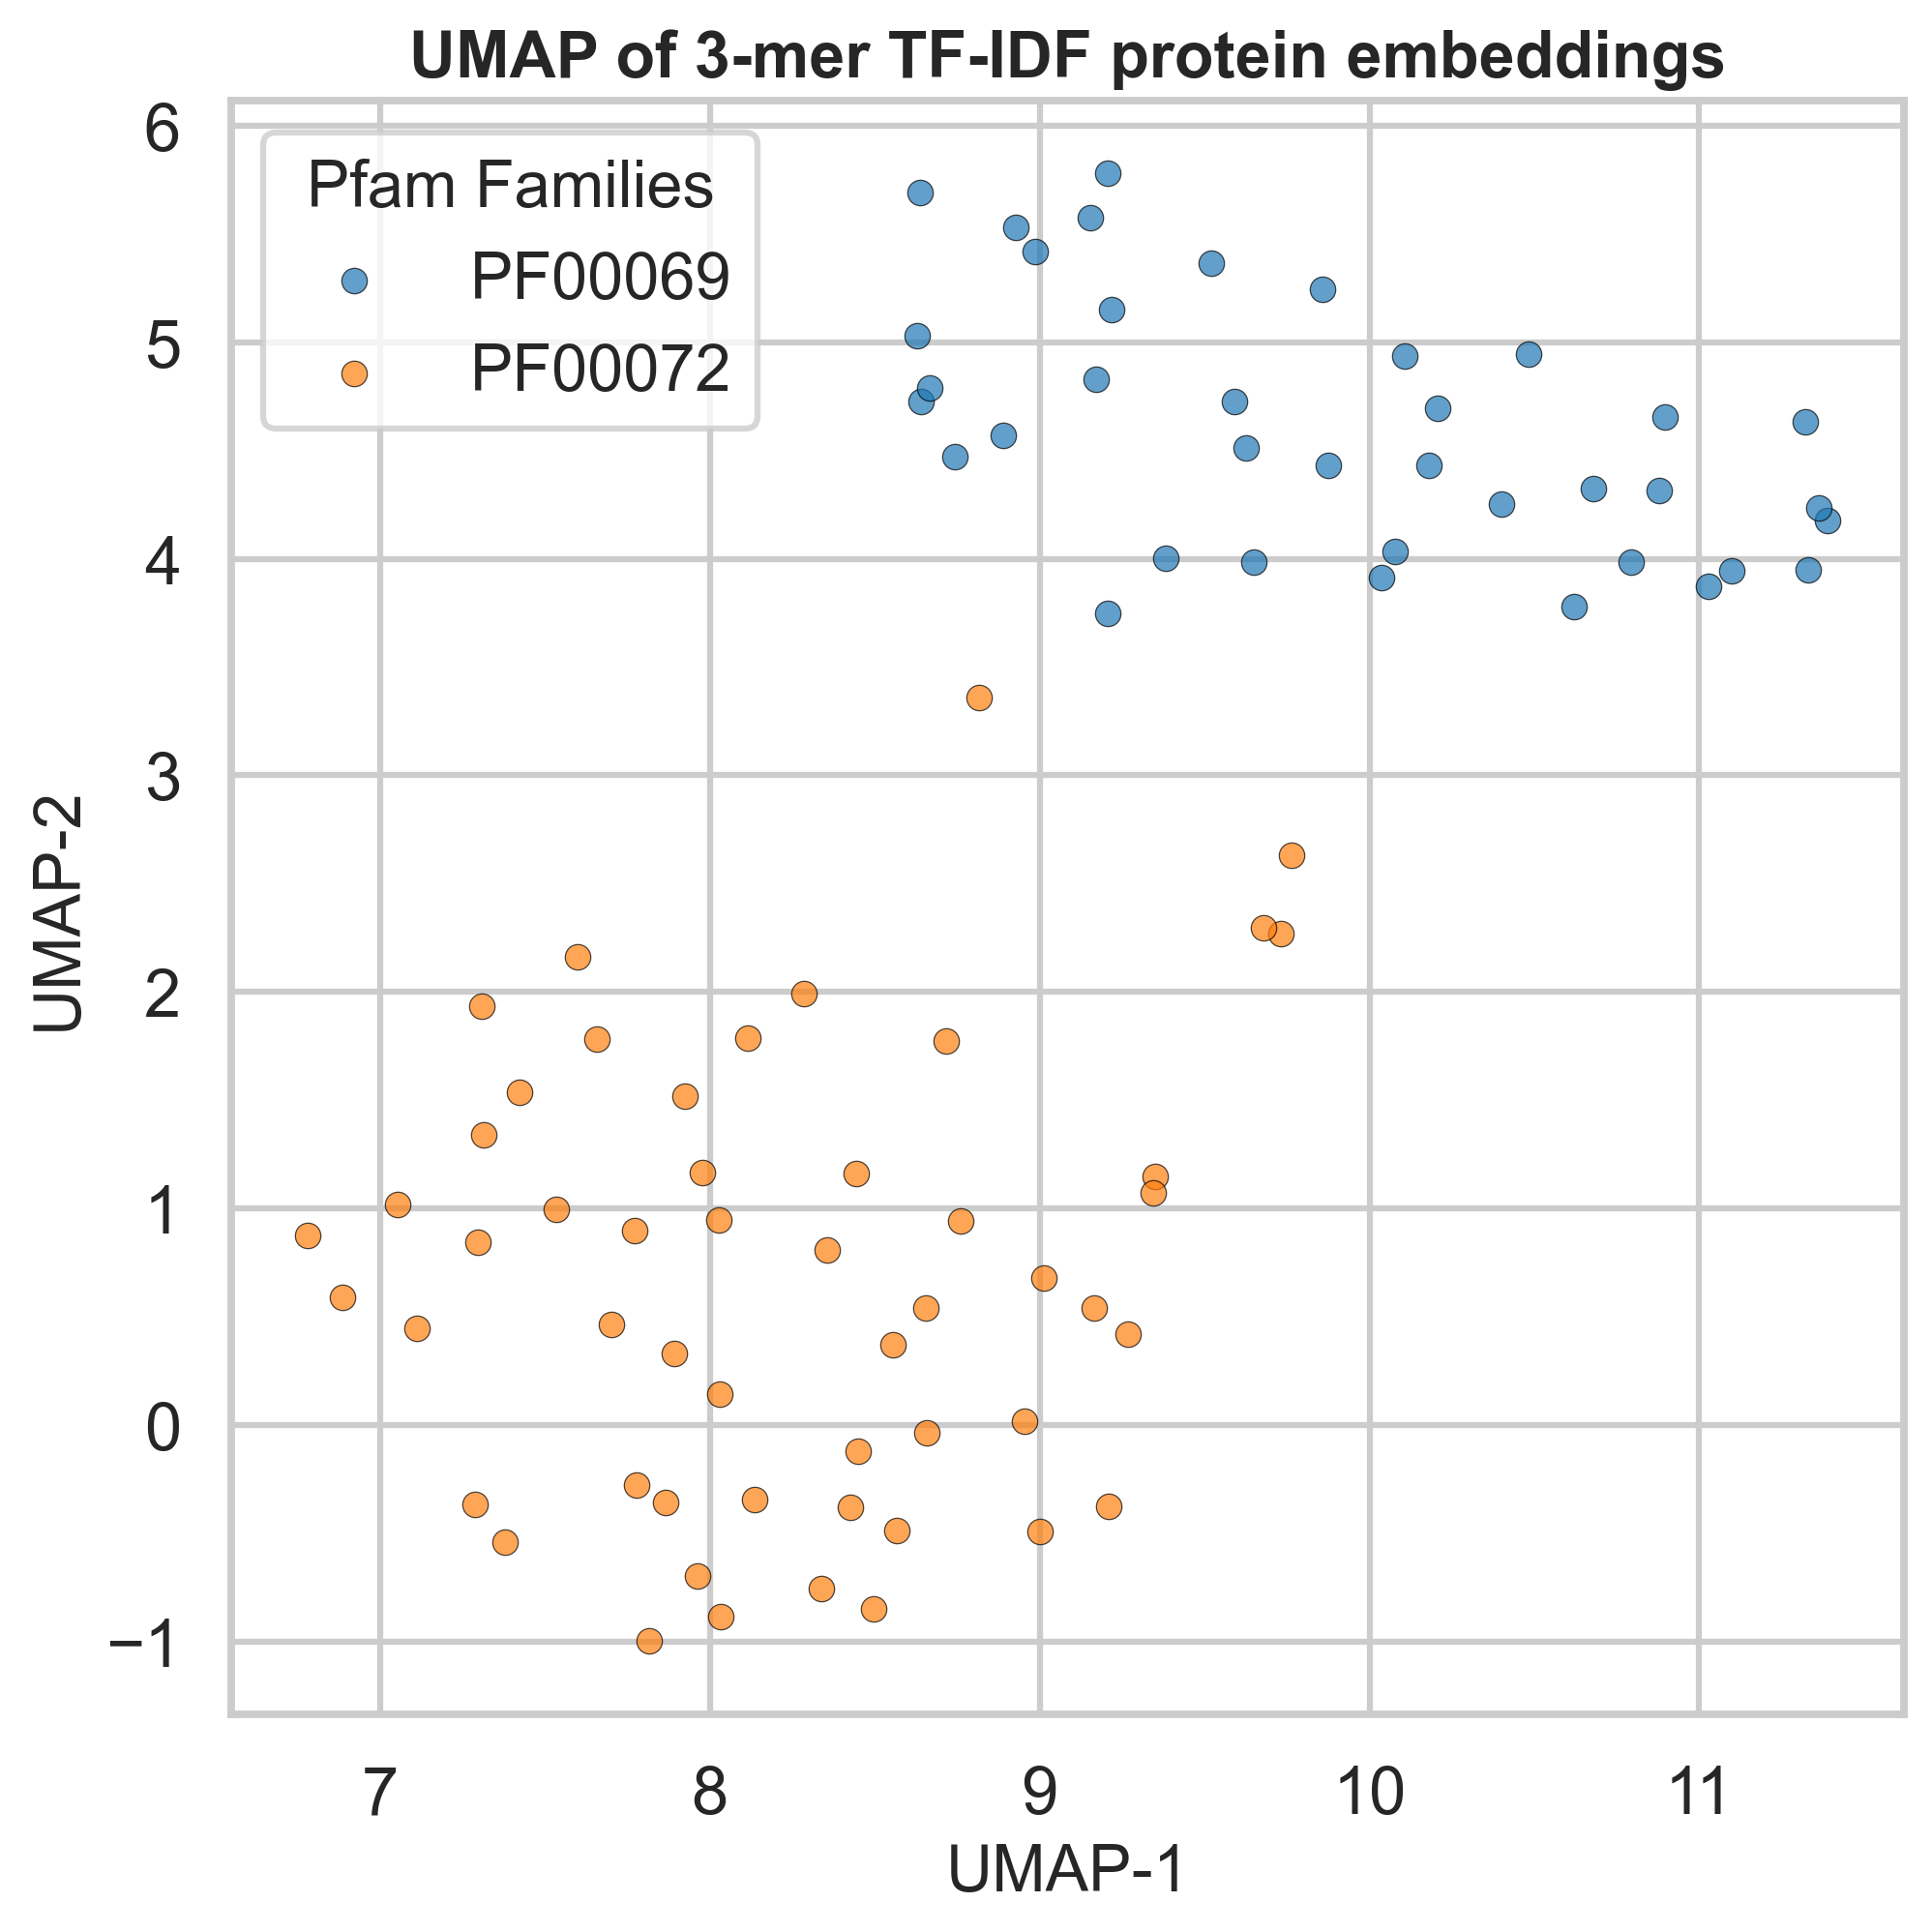

In [61]:
scatter_2d(X_umap, labels, "UMAP of 3-mer TF-IDF protein embeddings")

In [ ]:
# 5) Quantitative comparison vs your PCA view
#    We’ll compute (a) trustworthiness of the 2-D map and (b) simple 5-NN CV accuracy using the 2-D coords.
#    For PCA we’ll reuse your 'pcs' from the composition PCA step (pcs_composition here).
#    If your variable is named differently, just swap it in.

# First, rebuild the same subset order used for seq_texts/labels to align with PCA’s df order.
# We'll build an index from df that corresponds only to sequences we used in seq_texts/labels
import pandas as pd
aa_list = list("ACDEFGHIKLMNPQRSTVWY")
df_used = []    # rows of df matching seq_texts order
comp_rows = []  # to pull matching rows from your composition PCA
i = 0
for pfam, seqs in records_by_family.items():
    for rec in seqs:
        s = ''.join([c for c in str(rec.seq) if c in "ACDEFGHIKLMNPQRSTVWY"])
        if len(s) >= 50:
            # find the first matching row in df for this family (composition already computed)
            # note: this assumes df rows were created in the same iteration order (your code does that)
            df_used.append(True)
        else:
            df_used.append(False)

# Filter your composition DataFrame and PCA coords to the same subset
# (Your earlier PCA used df[aa_list] -> StandardScaler -> pca.fit_transform)
# We reconstruct it here to ensure alignment.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_comp = pd.DataFrame(
    [row for (row, keep) in zip(df[aa_list].values.tolist(), [k for k in df_used if k]) if keep],
    columns=aa_list
)
y = [lab for (lab, keep) in zip(df["family"].tolist(), [k for k in df_used if k]) if keep]

Xc = StandardScaler().fit_transform(df_comp.values)
pca2 = PCA(n_components=2, random_state=0)
pcs_composition = pca2.fit_transform(Xc)

# (a) Trustworthiness (higher is better; 1.0 max). Compare local structure preservation.
tw_umap = trustworthiness(X_kmer, X_umap, n_neighbors=10, metric='euclidean')
tw_tsne = trustworthiness(X_kmer, X_tsne, n_neighbors=10, metric='euclidean')
# For PCA on composition we need the high-dim “input” that led to pcs_composition, i.e., composition features:
tw_pca_comp = trustworthiness(Xc, pcs_composition, n_neighbors=10, metric='euclidean')

print(f"Trustworthiness — UMAP (k-mer): {tw_umap:.3f}")
print(f"Trustworthiness — t-SNE (k-mer): {tw_tsne:.3f}")
print(f"Trustworthiness — PCA (composition): {tw_pca_comp:.3f}")

# (b) 5-NN classification on the 2-D embeddings (higher accuracy => better class separation).
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def knn_cv_accuracy(Z, y):
    knn = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(knn, Z, y, cv=skf)
    return scores.mean(), scores.std()

acc_umap, sd_umap = knn_cv_accuracy(X_umap, y)
acc_tsne, sd_tsne = knn_cv_accuracy(X_tsne, y)
acc_pca, sd_pca = knn_cv_accuracy(pcs_composition, y)

print(f"5-NN CV accuracy — UMAP (k-mer): {acc_umap:.3f} ± {sd_umap:.3f}")
print(f"5-NN CV accuracy — t-SNE (k-mer): {acc_tsne:.3f} ± {sd_tsne:.3f}")
print(f"5-NN CV accuracy — PCA (composition): {acc_pca:.3f} ± {sd_pca:.3f}")
